In [1]:
import torch 
import math
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets
import os
import scipy
import sklearn
import seaborn as sns

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import balanced_accuracy_score

from src.evaluation import load_iccns
from src.utils import set_random_seeds
from hydra import initialize, compose
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from torch.nn import functional as F
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn import svm, tree
from aif360.sklearn.metrics import equal_opportunity_difference
from sklearn.neural_network import MLPClassifier

In [2]:
%matplotlib inline

In [3]:
set_random_seeds(65)

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## Experiment 4

In [4]:
def extract_attribute(file, attribute):
    
    if attribute in file:
            return attribute

def extract_method(string):
    for method in ["PCA", "Isomap", "SpectralEmbedding", "TSNE"]:
        if method in string:
                return method

In [5]:
# paths 
attribute = "Wearing_Hat"

celebA_csv = "../data/celeba/list_attr_celeba.csv"
uniform_csv = "../data/celeba/experiment1_uniform_sample.csv"

biased_csvs = ["../data/celeba/experiment1_biased_sample_{}_{}.csv".format(attribute, n) for n in [10,30,60,90]]
dataframes = [pd.read_csv(biased_csvs[i]) for i in range(4)]


In [6]:
unif_df = pd.read_csv(uniform_csv)

In [7]:
wasserstein_df = pd.read_csv("../results/Experiment4/wasserstein_2.tsv", sep= "\t", header=None)
wasserstein_df.columns = ["X", "Y", "features", "wasserstein"]

wasserstein_df["bias"] = wasserstein_df["features"].apply(lambda x: x.split("_")[2])
wasserstein_df["method"] = wasserstein_df["features"].apply(lambda x: extract_method(x))
wasserstein_df["dimension"] = wasserstein_df["features"].apply(lambda x: int(x.split("_")[-1]))
    
wasserstein_df.head()

,X,Y,features,wasserstein,bias,method,dimension
0,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,Wearing_Hat_10_red_TSNE_3,1.791002,10,TSNE,3
1,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,Wearing_Hat_30_red_TSNE_3,32.031707,30,TSNE,3
2,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,Wearing_Hat_60_red_TSNE_3,131.591411,60,TSNE,3
3,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,Wearing_Hat_90_red_TSNE_3,250.731857,90,TSNE,3
4,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,Wearing_Hat_10_red_PCA_3,0.067192,10,PCA,3


In [8]:
wasserstein = dict()
for method in ["PCA", "Isomap", "SpectralEmbedding"]:
    for i in [3, 50, 150]:
        wasserstein[method + " " + str(i)] = list(wasserstein_df[(wasserstein_df["method"]== method) & (wasserstein_df["dimension"] == i)].wasserstein)
        
wasserstein["TSNE 3"] = list(wasserstein_df[(wasserstein_df["method"]== "TSNE") & (wasserstein_df["dimension"] == 3)].wasserstein)

In [9]:
non_reduced = [2.8940860341390007,
7.7852453672621,
18.81794062889947,
34.12733239661323]

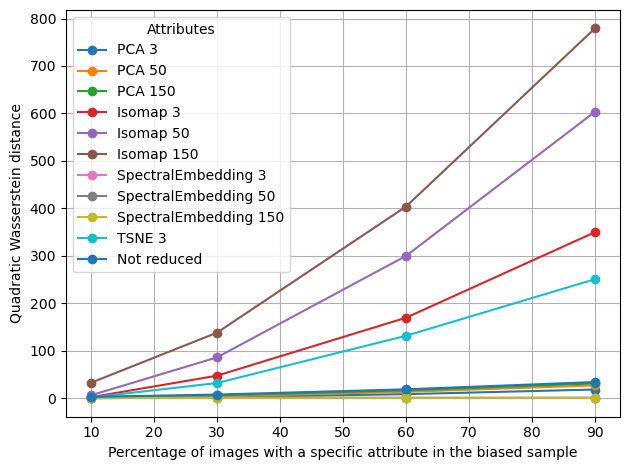

In [10]:
for i, item in enumerate(wasserstein.items()):

    attr, scores = item
    #c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o")

plt.plot([10,30,60,90], non_reduced, "-o")

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic Wasserstein distance")
plt.legend(list(wasserstein.keys()) + ["Not reduced"], title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment4/Wasserstein_distance_red_plot.png")
plt.show()

In [11]:
wasserstein["Not reduced"] = non_reduced

In [12]:
w_df = pd.DataFrame(wasserstein)

print(w_df.transpose().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &          0 &           1 &           2 &           3 \\
\midrule
PCA 3                 &   0.067192 &    2.244085 &    8.614960 &   18.378147 \\
PCA 50                &   0.650666 &    4.039413 &   13.508625 &   27.048151 \\
PCA 150               &   2.195677 &    6.000884 &   16.550436 &   31.129031 \\
Isomap 3              &   2.255729 &   47.547267 &  169.606831 &  349.713001 \\
Isomap 50             &   6.269205 &   86.103695 &  299.817519 &  603.284902 \\
Isomap 150            &  32.743821 &  138.202455 &  403.700374 &  779.032974 \\
SpectralEmbedding 3   &   1.191908 &    1.197371 &    1.187211 &    1.210802 \\
SpectralEmbedding 50  &   0.029279 &    0.029265 &    0.029258 &    0.029240 \\
SpectralEmbedding 150 &   0.080357 &    0.080329 &    0.080296 &    0.080257 \\
TSNE 3                &   1.791002 &   32.031707 &  131.591411 &  250.731857 \\
Not reduced           &   2.894086 &    7.785245 &   18.817941 &   34.127332 \\
\bottomrule
\end{t

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1190/3419837502.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(w_df.transpose().to_latex())


In [13]:
dataframes[0].columns

Index(['Unnamed: 0', 'image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'Kantorovich_potential',
       'resnet18_reduced_PCA_Kantorovich_potential',
       'resnet18_reduced_TSNE_Kantorovich_potential',
       'resnet18_reduced_PCA25_Kantorovich_potential',
       'resnet18_reduced_PCA50_Kantorovich_potential',
       'resnet18_reduced_PCA100_Kantorovich_potential',
       'resnet18_reduc

In [14]:
def fun(string):
    if len(string.split("/")) > 2:
        return "Potential"
    else:
        return string

In [17]:
corr = dict()

for i, n in enumerate([10, 30, 60, 90]):
    df = dataframes[i].rename(mapper=fun, axis=1)
    original = df["Potential"]
    corr["Wearing_Hat_{}".format(n)] = dict()
    for method in ["PCA", "Isomap", "SpectralEmbedding"]:
        for dimension in [3, 50 ,150]:
            if "Wearing_Hat_{}_red_{}_{}_2023-02-04_KP".format(n, method, dimension) in df.columns:
                col = "Wearing_Hat_{}_red_{}_{}_2023-02-04_KP".format(n, method, dimension)
            elif "Wearing_Hat_{}_red_{}_{}_2023-02-05_KP".format(n, method, dimension) in df.columns:
                col = "Wearing_Hat_{}_red_{}_{}_2023-02-05_KP".format(n, method, dimension)
            new = df[col]
            corr["Wearing_Hat_{}".format(n)][" ".join(col.split("_")[-4:-2])] = scipy.stats.spearmanr(new, original)
            
    col_tsne = "Wearing_Hat_{}_red_TSNE_3_2023-02-04_KP".format(n)
    new = df[col_tsne]
    corr["Wearing_Hat_{}".format(n)][" ".join(col_tsne.split("_")[-4:-2])] = scipy.stats.spearmanr(new, original)

In [18]:
for title, el in corr.items():
    c_df = pd.DataFrame(el)
    c_df = c_df.transpose()
    
    c_df.columns = ["Spearman r", "p-value"]
    
    print(c_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Spearman r &        p-value \\
\midrule
PCA 3                 &    0.534634 &   0.000000e+00 \\
PCA 50                &    0.559124 &   0.000000e+00 \\
PCA 150               &    0.615205 &   0.000000e+00 \\
Isomap 3              &    0.370849 &  1.863476e-291 \\
Isomap 50             &    0.354889 &  2.262858e-265 \\
Isomap 150            &    0.407618 &   0.000000e+00 \\
SpectralEmbedding 3   &   -0.139072 &   4.155244e-40 \\
SpectralEmbedding 50  &   -0.403923 &   0.000000e+00 \\
SpectralEmbedding 150 &   -0.477733 &   0.000000e+00 \\
TSNE 3                &    0.330672 &  1.412564e-228 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  Spearman r &  p-value \\
\midrule
PCA 3                 &    0.958580 &      0.0 \\
PCA 50                &    0.973337 &      0.0 \\
PCA 150               &    0.967237 &      0.0 \\
Isomap 3              &    0.847387 &      0.0 \\
Isomap 50             &    0.889826 &      0.0 \\
Isomap 150       

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1190/170903137.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(c_df.to_latex())
/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1190/170903137.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(c_df.to_latex())
/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1190/170903137.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementatio